In [1]:
%load_ext autoreload
%autoreload 2

## Test pipeline on one instance


In [2]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
import matplotlib.pyplot as plt
import numpy as np
import crepe

import utils as u
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [3]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"

audio_file_path = "audios/ggk1.wav"
pitch_est = PitchEstimator()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

spectrogram = np.abs(librosa.stft(y))

# Use median filtering to divide harmonic from percussive component
# NOTE: you can change margin and kernel_size and see the effect
# margin is related to the wiener-soft-mask
# kernel is the size of the filters that go over the spectrogram
harmonic, percussive = librosa.decompose.hpss(spectrogram, margin=16, kernel_size=31)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print("Harmonic component:")
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print("Percussive component:")
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


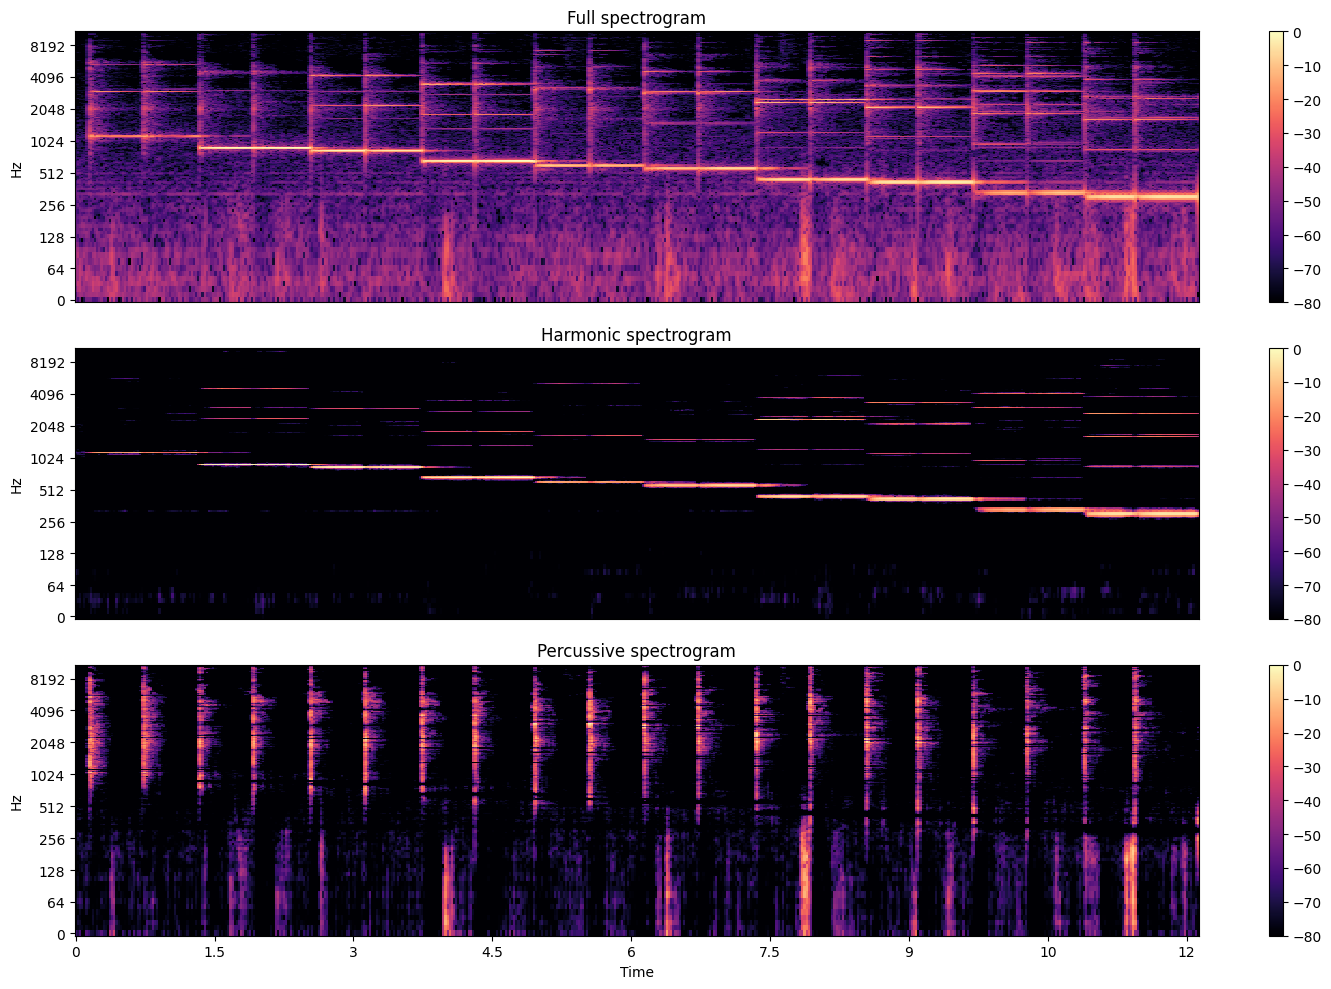

In [33]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

In [46]:
# comps, acts = librosa.decompose.decompose(spectrogram)

/home/stef/uni/mir/.mir/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


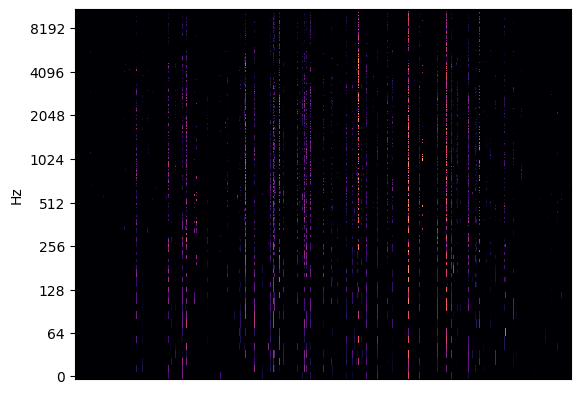

In [47]:
# librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis="log")

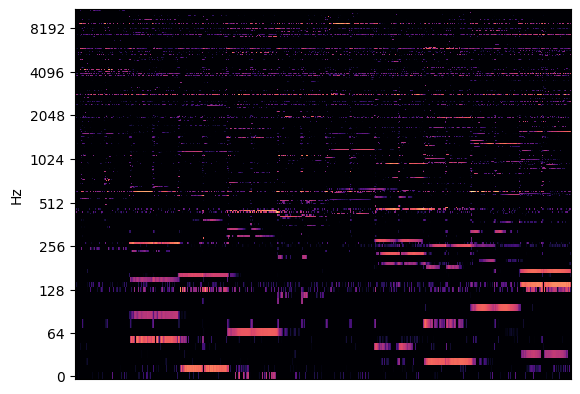

In [48]:
# librosa.display.specshow(librosa.amplitude_to_db(acts, ref=np.max), y_axis="log")


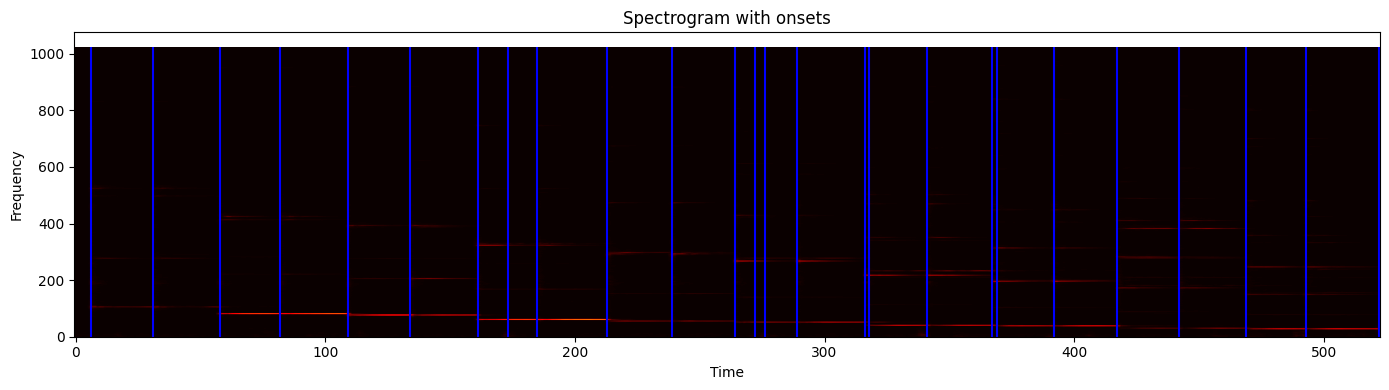

In [34]:
onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect="auto", origin="lower", cmap="hot")

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color="blue", linestyle="-")

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.set_title("Spectrogram with onsets")

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [65]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [8]:
time, frequency, confidence, activation = crepe.predict(harmonic_audio, sr, viterbi=True)

2024-03-14 20:42:49.143781: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 20:42:49.187959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 20:42:49.188130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 20:42:49.190428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 20:42:49.204326: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 20:42:49.208562: I tensorflow/core/platform/cpu_feature_guard.cc:1

38/38 [==============================] - 40s 1s/step


## Comparing CREPE with DSP techiniques

In [13]:
def detect_pitch(S, sr):
    # https://stackoverflow.com/questions/43877971/librosa-pitch-tracking-stft"""
    pitches, magnitudes = librosa.core.piptrack(S=S, sr=sr, fmin=75, fmax=1600)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

foo = detect_pitch(S=harmonic, sr=sr)

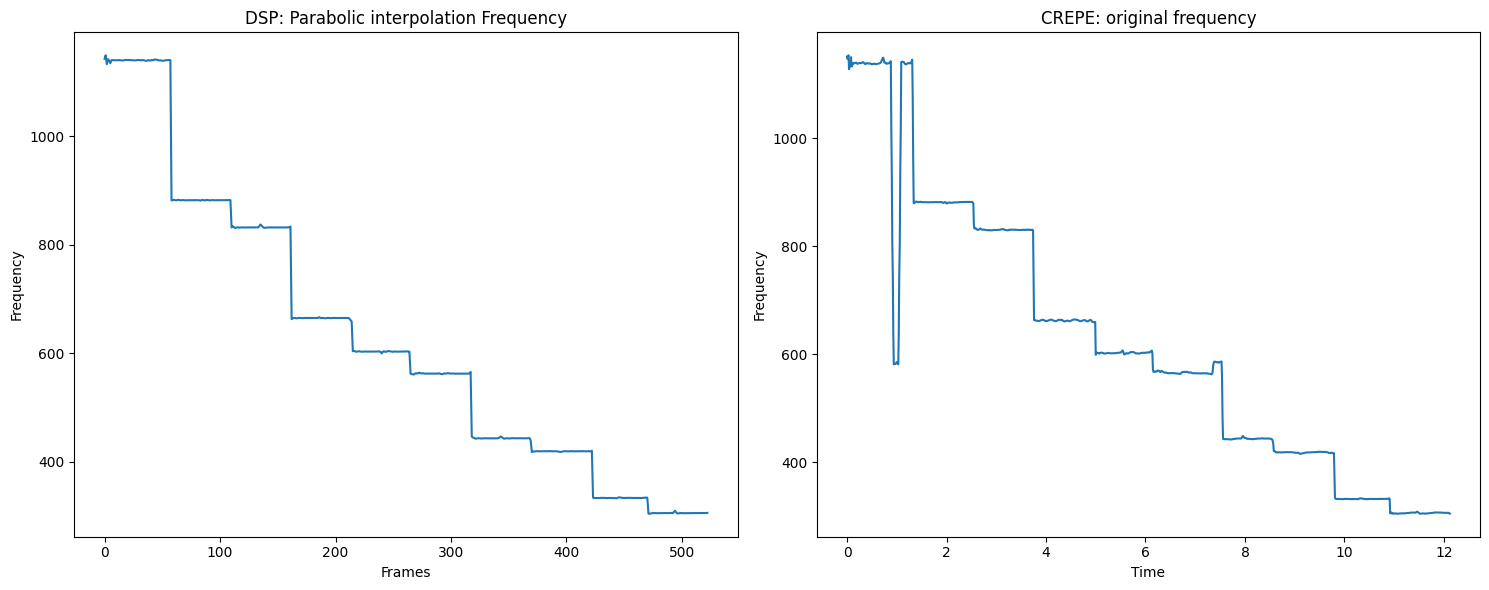

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

t = np.arange(len(foo))
# Plot new_frequency
ax1.plot(t, foo)
ax1.set_xlabel("Frames")
ax1.set_ylabel("Frequency")
ax1.set_title("DSP: Parabolic interpolation Frequency")

# Plot frequency
ax2.plot(time, frequency)
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")
ax2.set_title("CREPE: original frequency")

plt.tight_layout()
plt.show()

In [54]:
new_frequency = frequency.copy()
new_frequency[confidence < 0.6] = 0

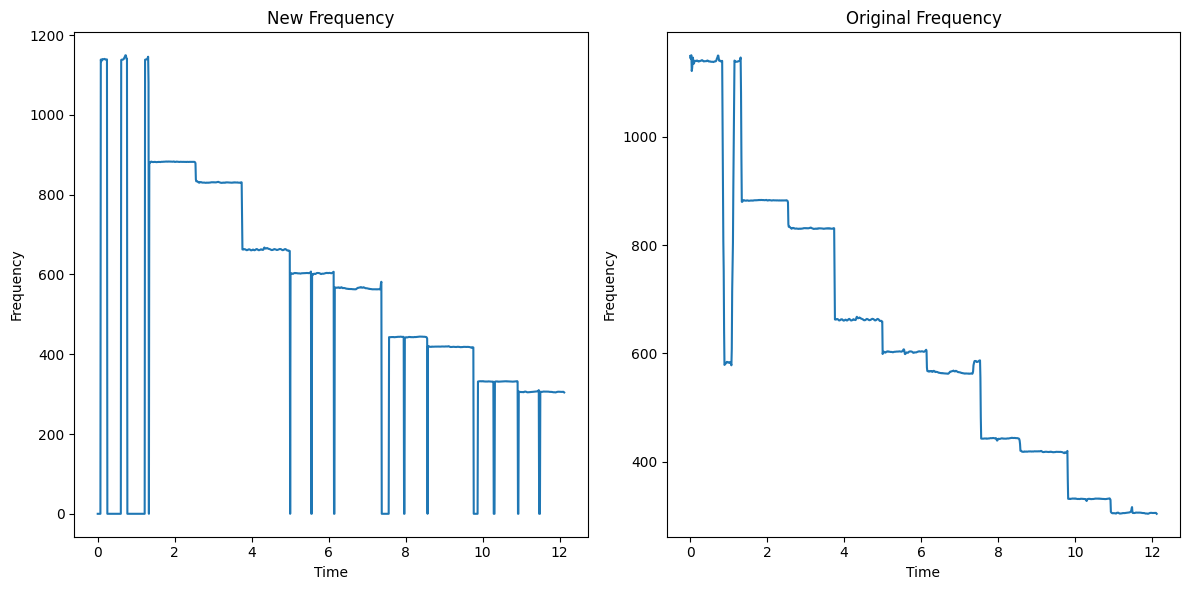

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot new_frequency
ax1.plot(time, new_frequency)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")
ax1.set_title("New Frequency")

# Plot frequency
ax2.plot(time, frequency)
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")
ax2.set_title("Original Frequency")

plt.tight_layout()
plt.show()

In [67]:
tones = []
stable_segments_idxs = []


for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1:
        index_b = len(time) - 1
    else:
        index_b = np.argmax(time > onsets[i + 1])

    frequency_segment = new_frequency[index_a:index_b]
    no_zero_seg = frequency_segment[frequency_segment != 0]
    # print(frequency_segment)
    # print(no_zero_seg)

    tone = np.median(frequency_segment)
    # tone = np.median(frequency_segment[frequency_segment > 0])
    if tone == 0:
        continue
    print(f"Onset median {i}-{i+1}: {tone}")
    print(f"Onset mean {i}-{i+1}: {np.mean(frequency_segment)}", "\n")

    print("----------")
    tones.append(tone)

Onset median 2-3: 882.4526297516236
Onset mean 2-3: 882.3996533441942 

----------
Onset median 3-4: 882.4072471357831
Onset mean 3-4: 882.4612479280321 

----------
Onset median 4-5: 830.9332766204607
Onset mean 4-5: 831.9295129041492 

----------
Onset median 5-6: 830.5574671150553
Onset mean 5-6: 830.5701539285461 

----------
Onset median 6-7: 662.5601814125607
Onset mean 6-7: 670.9657699415548 

----------
Onset median 7-8: 662.0460626117327
Onset mean 7-8: 662.0441506124715 

----------
Onset median 8-9: 662.9443054293978
Onset mean 8-9: 663.0490037248443 

----------
Onset median 9-10: 603.2819385437482
Onset mean 9-10: 597.8886555882035 

----------
Onset median 10-11: 603.1669865301534
Onset mean 10-11: 582.4127116500352 

----------
Onset median 11-12: 567.0388726448259
Onset mean 11-12: 504.04558211448665 

----------
Onset median 12-13: 566.7245184939164
Onset mean 12-13: 566.7177418884369 

----------
Onset median 13-14: 563.6283543000119
Onset mean 13-14: 563.772855367654

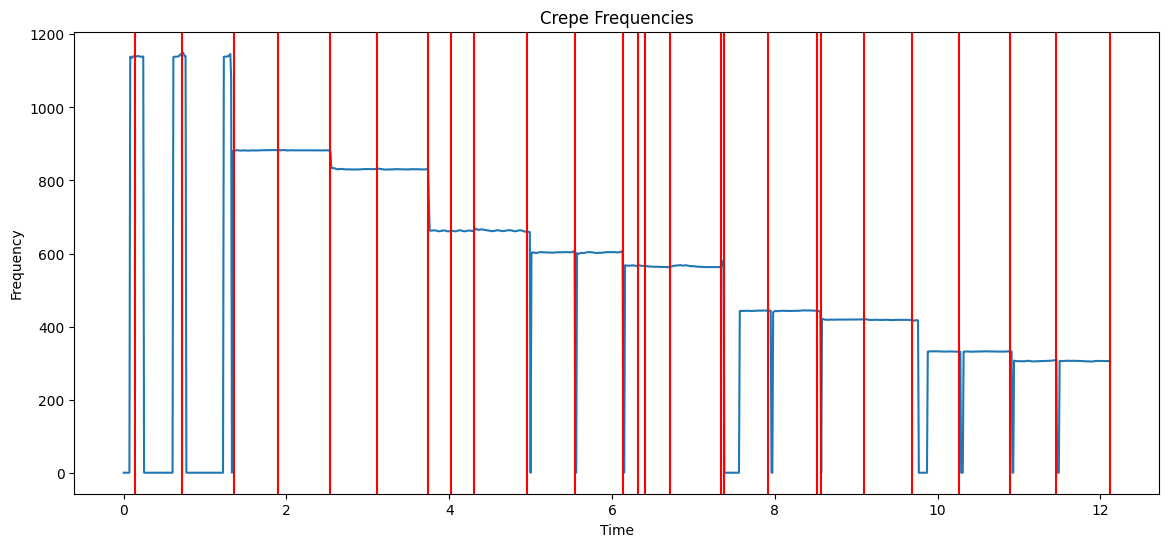

In [60]:
plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Plot the interpolated frequencies
plt.plot(time, new_frequency)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Crepe Frequencies")

for t in onsets:
    plt.axvline(x=round(t, 2), color="r", linestyle="-", label=f"Time {t}")

In [61]:
tone_group = u.group_and_average_frequencies(tones)
print(tone_group)

[305.57403864121864, 331.79985205387175, 418.81021229166834, 442.8498765673555, 565.3814600872503, 603.2244625369508, 662.5168498178972, 830.745371867758, 882.4299384437033, nan]


In [62]:
for tone in tone_group:
    audio = librosa.tone(tone, duration=1)
    print(f"Playing tone {tone}")
    display(ipd.Audio(audio, rate=sr))

Playing tone 305.57403864121864


Playing tone 331.79985205387175


Playing tone 418.81021229166834


Playing tone 442.8498765673555


Playing tone 565.3814600872503


Playing tone 603.2244625369508


Playing tone 662.5168498178972


Playing tone 830.745371867758


Playing tone 882.4299384437033


Playing tone nan


/home/stef/uni/mir/.mir/lib/python3.11/site-packages/IPython/lib/display.py:175: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


## Find out the tuning


In [63]:
def compute_distance(tone_a, tone_b):
    distance_in_cents = 1200 * np.log2(tone_b / tone_a)
    return distance_in_cents

distances = []

for i in range(len(tone_group) - 1):
    tone_a = tone_group[i]
    tone_b = tone_group[i + 1]
    d = compute_distance(tone_a, tone_b)
    print(f"Distance between {tone_a} and {tone_b}: {d} cents")
    distances.append(d)

Distance between 305.57403864121864 and 331.79985205387175: 142.54951776349608 cents
Distance between 331.79985205387175 and 418.81021229166834: 403.18005413183386 cents
Distance between 418.81021229166834 and 442.8498765673555: 96.62531435950733 cents
Distance between 442.8498765673555 and 565.3814600872503: 422.88823023508616 cents
Distance between 565.3814600872503 and 603.2244625369508: 112.16443207529778 cents
Distance between 603.2244625369508 and 662.5168498178972: 162.31465416647038 cents
Distance between 662.5168498178972 and 830.745371867758: 391.73904413750614 cents
Distance between 830.745371867758 and 882.4299384437033: 104.4904654472169 cents
Distance between 882.4299384437033 and nan: nan cents


In [64]:
for i in range(len(distances) - 1):
    if distances[i] < 200 and distances[i + 1] < 200:
        print(f"Found two consecutive values smaller than 220: {distances[i]} and {distances[i+1]}")
        scale = tone_group[i : i + 6]
        scale_distances = np.array(distances[i : i + 5])
        ding, dong, deng, dung, dang, hiding = scale
        break

print("---")
print(f"Ding: {ding}")
print(f"Dong: {dong}")
print(f"Deng: {deng}")
print(f"Dung: {dung}")
print(f"Dang: {dang}")
print(f"Hiding: {hiding}")
print("---")
print(f"Scale distances: {scale_distances}")

Found two consecutive values smaller than 220: 112.16443207529778 and 162.31465416647038
---
Ding: 565.3814600872503
Dong: 603.2244625369508
Deng: 662.5168498178972
Dung: 830.745371867758
Dang: 882.4299384437033
Hiding: nan
---
Scale distances: [112.16443208 162.31465417 391.73904414 104.49046545          nan]


In [45]:
begbeg = np.array([120, 114, 432, 81, 453])
sedang = np.array([136, 155, 379, 134, 396])
tirus = np.array([197, 180, 347, 104, 372])

similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
print(f"Cosine similarity to begbeg: {similarity[0]}")
print(f"Cosine similarity to sedang: {similarity[1]}")
print(f"Cosine similarity to tirus: {similarity[2]}")
print("-------")

eucl_distances = euclidean_distances(X=[scale_distances], Y=[begbeg, sedang, tirus])[0]
print(f"Euclidian distance to begbeg: {eucl_distances[0]}")
print(f"Euclidian distance to sedang: {eucl_distances[1]}")
print(f"Euclidian distance to tirus: {eucl_distances[2]}")

Cosine similarity to begbeg: 0.5584514701231972
Cosine similarity to sedang: 0.6433528032485728
Cosine similarity to tirus: 0.6028786932802636
-------
Euclidian distance to begbeg: 547.1706666001587
Euclidian distance to sedang: 463.56337297071656
Euclidian distance to tirus: 474.85260176161205


In [114]:
def gaussian_kernel(x, y, sigma=100):
    distance_squared = np.sum((x - y) ** 2)
    kernel_value = np.exp(-distance_squared / (2 * sigma**2))
    return kernel_value

for tuning_type in [begbeg, sedang, tirus]:
    print(f"Similarity to {tuning_type}: {gaussian_kernel(scale_distances, tuning_type)}")

Similarity to [120 114 432  81 453]: 3.452419395300167e-07
Similarity to [136 155 379 134 396]: 2.3092044921663508e-05
Similarity to [197 180 347 104 372]: 1.3781304193950537e-05
